# 1. Introducción a Stan y PyStan

Stan es un lenguaje que modela el análisis de datos para modelos Bayesianos, el trabajo real se realiza en C++ pero para nuestro caso vamos a utilizar una libreía de Python llamada PyStan la cual permite al desarrollador trabajar en Python y correr los modelos en C++.
## 1.1 Data




In [6]:
"""
data {                      // Bloque de Datos
  int<lower=1> N;           // Tamaño de la muestra
  int<lower=1> K;           // Dimensiónde la matriz
  matrix[N, K] X;           // Configuración de la matriz
  vector[N] y;              // Vector objetivo
}

"""

'\ndata {                      // Data block\n  int<lower=1> N;           // Sample size\n  int<lower=1> K;           // Dimension of model matrix\n  matrix[N, K] X;           // Model Matrix\n  vector[N] y;              // Target variable\n}\n\n'

La primera sección es el bloque de datos, donde le decimos a Stan los datos que debería esperar de la lista de datos. Es útil poner límites como verificación en la entrada de datos, (por ejemplo, el tamaño de una muestra). Las dos primeras variables declaradas son N y K, ambas como números enteros. A continuación, el código declara la matriz del modelo y el vector objetivo respectivamente. Como se observa y para los siguientes bloques, se declara el tipo y las dimensiones de la variable y luego su nombre. En Stan, todo lo declarado en un bloque está disponible para los bloques posteriores, pero los declarados en un bloque no pueden usarse en bloques anteriores. Incluso dentro de un bloque, cualquier cosa declarada, como N y K, se puede usar posteriormente, como hicimos para especificar las dimensiones de la matriz del modelo X.

## 1.2 Datos Transformados

In [ ]:
"""
transformed data {          // Bloque de datos transformados
  vector[N] logX;
  
  logX = log(X);
} 
"""

El bloque de datos transformado es donde puede hacer cosas convertir una variable a un logaritmo por ejemplo, es decir, se puede crear nuevos datos basados en los datos de entrada o simplemente en general.También se puede declarar aquí cualquier parámetro no modelado, por ejemplo aquellos que se les desea fijar algún valor.

## 1.3 Parámetros

In [ ]:
"""
parameters {                // Parameters block
  vector[K] beta;           // Coefficient vector
  real<lower=0> sigma;      // Error scale
}
"""

Los principales parámetros de interés que se van a estimar se definen en el bloque de parámetros. Al igual que con el bloque de datos, solo se pueden declarar estas variables, no se puede realizar ninguna asignación. Se puede observara que para este ejemplo se van a estimar el β y el Sigma, con un límite inferior de cero en este último. En la práctica, es posible que prefiera dividir algunos parámetros para ser modelarlos por separado si se encuentran en escalas notablemente diferentes.

## 1.4 Modelo


In [ ]:
"""
model {                     // Bloque del modelo
  vector[N] mu;
  mu = X * beta;            // Predictor lineal
  
  // priors
  beta ~ normal(0, 10);
  sigma ~ cauchy(0, 5);     
  
  // likelihood
  y ~ normal(mu, sigma);
}
"""

El bloque del modelo es donde se especifican las distribuciones previas y muestrales, junto con la declaración de cualquier variable necesaria. Como ejemplo, aquí se incluye el predictor lineal, ya que se incluirá en el likelihood. 

# 2. Ejemplo Comparativo de un modelo Jerárquico Bayesiano

La idea es tratar de crear una predicción para explicar y poder predicir el consumo de millas por galón (MPG) de un set de carros de diferentes especificaciones y marcas. Parte de la información que tienen los datos es la siguiente.

<ul>
  <li>mpg: contínuo</li>
  <li>cilindros: entero</li>
  <li>desplazamiento: contínuo</li>
    <li>caballos de fuerza: contínuo</li>
    <li>peso: contínuo</li>
    <li>aceleración: contínuo</li>
    <li>año: entero</li>
    <li>origen: categórico</li>
    <li>nombre del carro: string</li>
    
</ul>

Para poder realizar la comparación de cómo se comporta un modelo Bayesiano, también se va a utilizar un modelo de regresión lineal simple para realizar las predicciones. La ecuación a utilizar para ambos casos va a ser la siguiente: **Y = α + Xβ + ε**  donde Y corresponde a nuestra variable de interés, que para este ejemplo son los **MPG**. X representa las variables independientes, aplha representa la intercepción y Beta representa el vector con los coeficientes característicos. Por último el error, el cual va a seguir una distribución normal para este ejemplo. Ahora, cual es la diferencia con el modelo Bayesiano, la diferencia radica en que cada uno de estos factores van a tener una distribución previa, tanto para alpha, beta y sigma. Por esto debemos hacer preguntas como ¿Cúal es mi distribución muestral?, ¿Qué tipo de distribución sigue mi modelo?, ¿Cúales son mis parámetros, que tipo de valores previos debo escoger?




In [1]:
#Se importan las librerias a utilizar

from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pystan
import seaborn as sns
import pandas as pd
from theano import shared
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import r2_score
import copy
import sklearn
plt.style.use('bmh')

In [2]:
#Lectura del data set
cars_data = pd.read_csv("cars.csv").set_index("name")
print(cars_data.shape)
cars_data.head()

(398, 8)


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,American
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,American
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,American
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,American
ford torino,17.0,8,302.0,140,3449,10.5,70,American


Para entender mejor los datos, vamos a plotear los datos de tal manera que sepamos más infomación visual de nuestra variable de interés MPG.

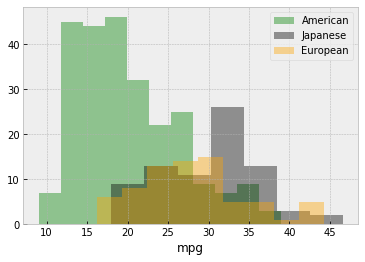

In [3]:
sns.distplot(cars_data[cars_data['origin']=='American']['mpg'],color="green", label="American",kde=False)
sns.distplot(cars_data[cars_data['origin']=='Japanese']['mpg'],color="black", label="Japanese",kde=False)
sns.distplot(cars_data[cars_data['origin']=='European']['mpg'],color="orange", label="European",kde=False)
plt.legend()

Se nota una clara diferencia entre los carros americanos y los japoneses. Ahora se va a graficar las variables en cuestión, y entender como se relacionan con la variable de interés.

C:\Users\vernyjmo\Miniconda3\envs\py3\lib\site-packages\seaborn\relational.py:1656: UserWarning: relplot is a figure-level function and does not accept target axes. You may wish to try scatterplot
  warnings.warn(msg, UserWarning)


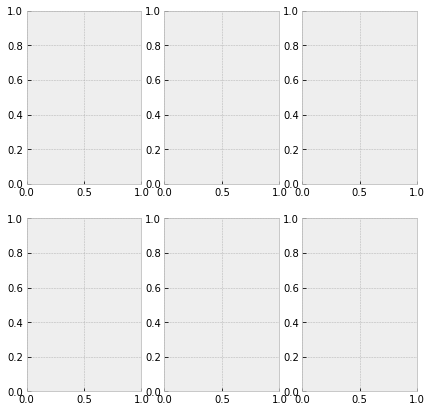

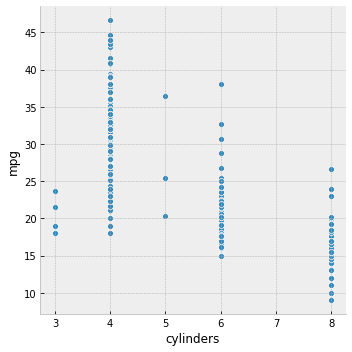

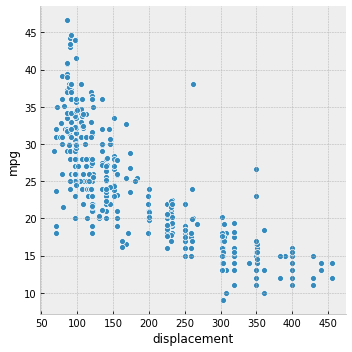

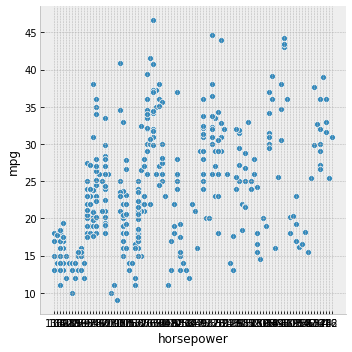

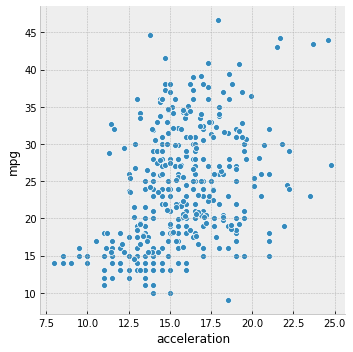

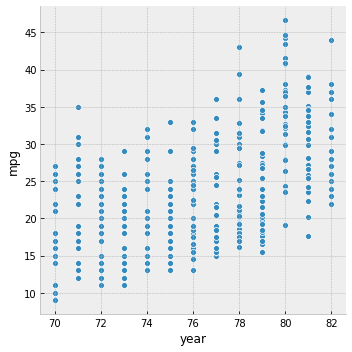

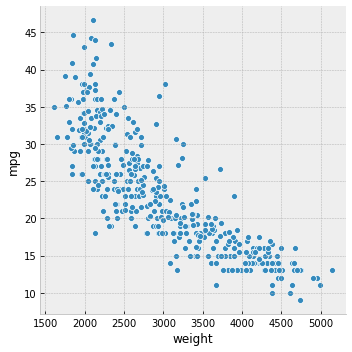

In [4]:
f, axes = plt.subplots(2, 3, figsize=(7, 7), sharex=False)


sns.relplot(x="cylinders", y="mpg", data=cars_data, ax=axes[0, 0]);
sns.relplot(x="displacement", y="mpg", data=cars_data, ax=axes[0, 1]);
sns.relplot(x="horsepower", y="mpg", data=cars_data, ax=axes[0, 2]);
sns.relplot(x="acceleration", y="mpg", data=cars_data, ax=axes[1, 0]);
sns.relplot(x="year", y="mpg", data=cars_data, ax=axes[1, 1]);
sns.relplot(x="weight", y="mpg", data=cars_data, ax=axes[1, 2]);
    
plt.show()

Se observa que todas las variables menos el año y la aceleración se relacionan de manera negativa a los MPG. Ahora se van a preparar los datos para su entrenamiento y sus estimaciones. Primero se realiza la regresión lineal de tipo OLS (Ordinary Least Square).

In [5]:
import statsmodels.api as statmod
from numpy import random
from sklearn import preprocessing, metrics, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

random.seed(12345)


cars_data_vars = cars_data.columns.values[:-1].tolist()

y = cars_data['mpg']
X = cars_data.loc[:, cars_data.columns != 'mpg']
X = X.loc[:, X.columns != 'name']
X = pd.get_dummies(X, prefix_sep='_', drop_first=False)
X = X.drop(columns=["origin_European"]) #Categoria de referencia
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)



In [6]:
# Fit y resumen del modelo OLS
X_train['const'] = 1; X_test['const'] = 1

mod1 = statmod.OLS(y_train, X_train, prepend=False)
res = mod1.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     23.72
Date:                Sun, 14 Mar 2021   Prob (F-statistic):           9.18e-79
Time:                        16:42:59   Log-Likelihood:                -739.70
No. Observations:                 318   AIC:                             1657.
Df Residuals:                     229   BIC:                             1992.
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
cylinders          -0.0583      0.508     

C:\Users\vernyjmo\Miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
y_train_freq = res.predict(X_train)
y_test_freq = res.predict(X_test)

In [8]:
freq_test_mse = metrics.mean_squared_error(y_test, y_test_freq)
print('Freq Test MSE:', freq_test_mse)

Freq Test MSE: 9.03566713233056


In [9]:
#Calculo del RSquared2

r2_Score = r2_score(y_test, y_test_freq)
print(r2_Score)

0.8396257195269818


In [10]:
#Calculo mean Abosulte error MAE

from sklearn.metrics import mean_absolute_error

MAE = mean_absolute_error(y_test, y_test_freq)
print(MAE)

2.3633974304114345


## KERAS NEURAL NETWORK

In [11]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [14]:
reg = MLPRegressor(hidden_layer_sizes=(64,64,64),activation="relu" ,random_state=1, max_iter=2000).fit(X_train, y_train)

In [15]:
y_pred=reg.predict(X_test)

In [16]:
NN_mse = metrics.mean_squared_error(y_test,y_pred)
print('Freq Test MSE:', NN_mse)

Freq Test MSE: 7.4821044212576835


In [17]:
NN_r2_Score = r2_score(y_test, y_pred)
print('Freq Test MSE:', NN_r2_Score)

Freq Test MSE: 0.8671999426926996


In [18]:
NN_MAE = mean_absolute_error(y_test, y_pred)
print(NN_MAE)

2.139049516996809


## HBM

Una vez encontrado el error cuadrático medio para este estudio, procederemos a hacer el cálculo del mismo utilizando los modelos Bayesianos.

In [19]:
from numpy import random
from sklearn import preprocessing, metrics, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

random.seed(12345)


In [20]:
y = cars_data['mpg']
X = cars_data.loc[:, cars_data.columns != 'mpg']
X = X.loc[:, X.columns != 'name']
X = pd.get_dummies(X, prefix_sep='_', drop_first=False)
X = X.drop(columns=["origin_European"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [21]:
cars_code = """
data {
    int<lower=1> N; // number of training samples
    int<lower=0> K; // number of predictors
    matrix[N, K] x; // matrix of predictors
    vector[N] y_obs; // observed/training mpg
    
    int<lower=1> N_new;
    matrix[N_new, K] x_new;
}
parameters {
    real alpha;
    vector[K] beta;
    //vector[K] tau;
    real<lower=0> sigma;
    
    vector[N_new] y_new;
}
transformed parameters {
    vector[N] theta;
    theta = alpha + x * beta;
}
model {
    sigma ~ exponential(1);
    alpha ~ normal(0, 6);
    beta ~ multi_normal(rep_vector(0, K), diag_matrix(rep_vector(1, K)));
    y_obs ~ normal(theta, sigma);
    
    y_new ~ normal(alpha + x_new * beta, sigma); // prediction model
}
"""

In [22]:
cars_dat = {'N': X_train.shape[0],
            'N_new': X_test.shape[0],
            'K': X_train.shape[1],
            'y_obs': y_train.values.tolist(),
            'x': np.array(X_train),
            'x_new': np.array(X_test)}


sm = pystan.StanModel(model_code=cars_code)
fit = sm.sampling(data=cars_dat, iter=6000, chains=8)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3112a6cce1c41eead6e39aa4b53ccc8b NOW.


In [23]:
la = fit.extract(permuted=True)
bay_test_mse = metrics.mean_squared_error(y_test, la['y_new'].mean(0))
print('Bayes Test MSE:', bay_test_mse)

Bayes Test MSE: 6.473744070270999


In [24]:
#Calculo del RSquared2 para el modelo Bayesiano

r2_Score_Bayes = r2_score(y_test, la['y_new'].mean(0))
print(r2_Score_Bayes)

0.8850973556206699


In [25]:
#Calculo Mean Squared Error para el modelo Bayesiano

MAE_Bayes = mean_absolute_error(y_test, la['y_new'].mean(0))
print(MAE_Bayes)

1.8993780147398425


## Resultados Obtenidos

Como se pued eobservar en la siguiente tabla el desempeño en general del model Jerárquico Bayesiano fue mejor al de la Regresión simple, obteniendo un menor error cuadrático. Además obtuvo un mejor correlación de los datos al obtener un R2 mayor. Además, al obtener un MAE menor, también demuestra que el error de los datos predecidos es menor. 

| Modelo                          | MSE         | R-Squared(R2)    | MAE           |
| :---                            |    :----:   |          ---:    |          ---: |
|Modelo Regresion Lineal          |9.03         | 0.84             | 2.36          |
|Red Neuronal                     |7.48         | 0.87             | 2.14          |   
|Modelo Jerárquico Bayesiano      |6.47         | 0.88             | 1.90          |

R-squared (R2), which is the proportion of variation in the outcome that is explained by the predictor variables. In multiple regression models, R2 corresponds to the squared correlation between the observed outcome values and the predicted values by the model. The Higher the R-squared, the better the model.

Root Mean Squared Error (RMSE), which measures the average error performed by the model in predicting the outcome for an observation. Mathematically, the RMSE is the square root of the mean squared error (MSE), which is the average squared difference between the observed actual outome values and the values predicted by the model. So, MSE = mean((observeds - predicteds)^2) and RMSE = sqrt(MSE). The lower the RMSE, the better the model.

Residual Standard Error (RSE), also known as the model sigma, is a variant of the RMSE adjusted for the number of predictors in the model. The lower the RSE, the better the model. In practice, the difference between RMSE and RSE is very small, particularly for large multivariate data.

Mean Absolute Error (MAE), like the RMSE, the MAE measures the prediction error. Mathematically, it is the average absolute difference between observed and predicted outcomes, MAE = mean(abs(observeds - predicteds)). MAE is less sensitive to outliers compared to RMSE.